# COVID-19 World Overview
> Tracking coronavirus total cases, deaths and new cases by country.

- comments: true
- author: AJ
- categories: [overview, interactive]
- image: images/covid.PNG
- permalink: /covid-overview/
- hide: false

This notebook is update daily to meet current stats. Feel free to comment and give feedback!

In [1]:
#hide
import numpy as np
import pandas as pd
from jinja2 import Template
from IPython.display import HTML
import altair as alt
import matplotlib.pyplot as plt

In [2]:
#hide

# FETCH
base_url = 'https://raw.githubusercontent.com/pratapvardhan/notebooks/master/covid19/'
paths = {
    'mapping': '/Users/BEBETO/Documents/GitHub/SL_Covid19_Blog/assets/countryContinent.csv',
    'overview': '/Users/BEBETO/Documents/GitHub/SL_Covid19_Blog/assets/overview.tpl'
}

def get_mappings(url):
    df = pd.read_csv(url, encoding='"ISO-8859-1"')
    return {
        'df': df,
        'replace.country': dict(df.dropna(subset=['Name']).set_index('Country')['Name']),
        'map.continent': dict(df.set_index('Name')['Continent'])
    }


In [3]:
#hide
mapping = get_mappings(paths['mapping'])

def get_template(path):
    from urllib.parse import urlparse
    if bool(urlparse(path).netloc):
        from urllib.request import urlopen
        return urlopen(path).read().decode('utf8')
    return open(path).read()

def get_frame(name):
    url = (
        'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/'
        f'csse_covid_19_time_series/time_series_covid19_{name}_global.csv')
    df = pd.read_csv(url)
    # rename countries
    df['Country/Region'] = df['Country/Region'].replace(mapping['replace.country'])
    return df

def get_dates(df):
    dt_cols = df.columns[~df.columns.isin(['Province/State', 'Country/Region', 'Lat', 'Long'])]
    LAST_DATE_I = -1
    # sometimes last column may be empty, then go backwards
    for i in range(-1, -len(dt_cols), -1):
        if not df[dt_cols[i]].fillna(0).eq(0).all():
            LAST_DATE_I = i
            break
    return LAST_DATE_I, dt_cols

In [4]:
#hide
COL_REGION = 'Country/Region'
# Confirmed, Recovered, Deaths
df = get_frame('confirmed')
# dft_: timeseries, dfc_: today country agg
dft_cases = df
dft_deaths = get_frame('deaths')
dft_recovered = get_frame('recovered')
LAST_DATE_I, dt_cols = get_dates(df)

dt_today = dt_cols[LAST_DATE_I]
dt_5ago = dt_cols[LAST_DATE_I-5]


dfc_cases = dft_cases.groupby(COL_REGION)[dt_today].sum()
dfc_recoveries = dft_recovered.groupby(COL_REGION)[dt_today].sum()
dfc_deaths = dft_deaths.groupby(COL_REGION)[dt_today].sum()
dfp_cases = dft_cases.groupby(COL_REGION)[dt_5ago].sum()
dfp_recoveries = dft_recovered.groupby(COL_REGION)[dt_5ago].sum()
dfp_deaths = dft_deaths.groupby(COL_REGION)[dt_5ago].sum()

In [5]:
#hide
df_table = (pd.DataFrame(dict(Cases=dfc_cases, Recoveries=dfc_recoveries, Deaths=dfc_deaths, PCases=dfp_cases, 
                              PRecoveries = dfp_recoveries, PDeaths=dfp_deaths))
             .sort_values(by=['Cases', 'Deaths'], ascending=[False, False])
             .reset_index())
df_table.rename(columns={'index': 'Country/Region'}, inplace=True)
for c in 'Cases, Deaths, Recoveries'.split(', '):
    df_table[f'{c} (+)'] = (df_table[c] - df_table[f'P{c}']).clip(0)  # DATA BUG
df_table['Fatality Rate'] = (100 * df_table['Deaths'] / df_table['Cases']).round(1)
df_table['Recovery Rate'] = (100 * df_table['Recoveries'] / df_table['Cases']).round(1)
df_table['Continent'] = df_table['Country/Region'].map(mapping['map.continent'])
df_table.tail()

,Country/Region,Cases,Recoveries,Deaths,PCases,PRecoveries,PDeaths,Cases (+),Deaths (+),Recoveries (+),Fatality Rate,Recovery Rate,Continent
179,Western Sahara,4,0,0,0,0,0,4,0,0,0.0,0.0,Africa
180,Burundi,3,0,0,3,0,0,0,0,0,0.0,0.0,Africa
181,South Sudan,3,0,0,0,0,0,3,0,0,0.0,0.0,Africa
182,Papua New Guinea,2,0,0,1,0,0,1,0,0,0.0,0.0,Oceania
183,Timor-Leste,1,0,0,1,0,0,0,0,0,0.0,0.0,Asia


In [6]:
#hide
# world, china, europe, us
metrics = ['Cases', 'Recoveries', 'Deaths', 'Cases (+)', 'Recoveries (+)', 'Deaths (+)']
s_china = df_table[df_table['Country/Region'].eq('China')][metrics].sum().add_prefix('China ')
s_us = df_table[df_table['Country/Region'].eq('US')][metrics].sum().add_prefix('US ')
s_eu = df_table[df_table['Continent'].eq('Europe')][metrics].sum().add_prefix('EU ')
summary = {'updated': pd.to_datetime(dt_today), 'since': pd.to_datetime(dt_5ago)}
summary = {**summary, **df_table[metrics].sum(), **s_china, **s_us, **s_eu}
summary

{'updated': Timestamp('2020-04-09 00:00:00'),
 'since': Timestamp('2020-04-04 00:00:00'),
 'Cases': 1595350,
 'Recoveries': 353975,
 'Deaths': 95455,
 'Cases (+)': 397942,
 'Recoveries (+)': 107852,
 'Deaths (+)': 30850,
 'China Cases': 82883,
 'China Recoveries': 77679,
 'China Deaths': 3339,
 'China Cases (+)': 340,
 'China Recoveries (+)': 733,
 'China Deaths (+)': 9,
 'US Cases': 461437,
 'US Recoveries': 25410,
 'US Deaths': 16478,
 'US Cases (+)': 152584,
 'US Recoveries (+)': 10758,
 'US Deaths (+)': 8071,
 'EU Cases': 763106,
 'EU Recoveries': 184431,
 'EU Deaths': 65632,
 'EU Cases (+)': 157022,
 'EU Recoveries (+)': 70515,
 'EU Deaths (+)': 19541}

In [7]:
#hide
dft_ct_cases = dft_cases.groupby(COL_REGION)[dt_cols].sum()
dft_ct_new_cases = dft_ct_cases.diff(axis=1).fillna(0).astype(int)
dft_ct_new_cases.head()

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20
Country/Region,,,,,,,,,,,,,,,,,,,,,
Afghanistan,0,0,0,0,0,0,0,0,0,0,...,4,63,36,8,18,50,18,56,21,40
Albania,0,0,0,0,0,0,0,0,0,0,...,20,16,18,27,29,28,16,6,17,9
Algeria,0,0,0,0,0,0,0,0,0,0,...,132,131,139,185,80,69,103,45,104,94
Andorra,0,0,0,0,0,0,0,0,0,0,...,6,14,38,11,27,35,24,20,19,19
Angola,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,2,4,2,1,2,0


In [8]:
#hide_input
template = Template(get_template(paths['overview']))
html = template.render(
    D=summary, table=df_table,  # REMOVE .head(20) to see all values
    newcases=dft_ct_new_cases.loc[:, dt_cols[LAST_DATE_I-50]:dt_cols[LAST_DATE_I]],
    np=np, pd=pd, enumerate=enumerate)
HTML(f'<div>{html}</div>')

In [9]:
#hide
dft_ct_new_cases.reset_index(inplace=True)

In [10]:
#hide
cols = dft_ct_new_cases.keys()
confirmed = dft_ct_new_cases.loc[:, cols[1]:cols[-1]]
dates = confirmed.keys()
world_cases = []
china_cases = [] 
italy_cases = []
us_cases = [] 
spain_cases = [] 
germany_cases = []
france_cases = []

for i in dates:
    # case studies
    confirmed_sum = confirmed[i].sum()
    world_cases.append(confirmed_sum)
    china_cases.append(dft_ct_new_cases[dft_ct_new_cases['Country/Region']=='China'][i].sum())
    italy_cases.append(dft_ct_new_cases[dft_ct_new_cases['Country/Region']=='Italy'][i].sum())
    us_cases.append(dft_ct_new_cases[dft_ct_new_cases['Country/Region']=='US'][i].sum())
    spain_cases.append(dft_ct_new_cases[dft_ct_new_cases['Country/Region']=='Spain'][i].sum())
    germany_cases.append(dft_ct_new_cases[dft_ct_new_cases['Country/Region']=='Germany'][i].sum())
    france_cases.append(dft_ct_new_cases[dft_ct_new_cases['Country/Region']=='France'][i].sum())

In [11]:
#hide
def daily_increase(data):
    d = [] 
    for i in range(len(data)):
        if i == 0:
            d.append(data[0])
        else:
            d.append(data[i]- data[i-1])
    return d

world_daily_increase = daily_increase(world_cases)
china_daily_increase = daily_increase(china_cases)
italy_daily_increase = daily_increase(italy_cases)
us_daily_increase = daily_increase(us_cases)
spain_daily_increase = daily_increase(spain_cases)
germany_daily_increase = daily_increase(germany_cases)
france_daily_increase = daily_increase(france_cases)

In [12]:
#hide
days_in_future = 10
future_forcast = np.array([i for i in range(len(dates)+days_in_future)]).reshape(-1, 1)
adjusted_dates = future_forcast[:-10]

In [13]:
#hide
adjusted_dates = adjusted_dates.reshape(1, -1)[0]
len(adjusted_dates)

79

# World Coronavirus Cases Overtime

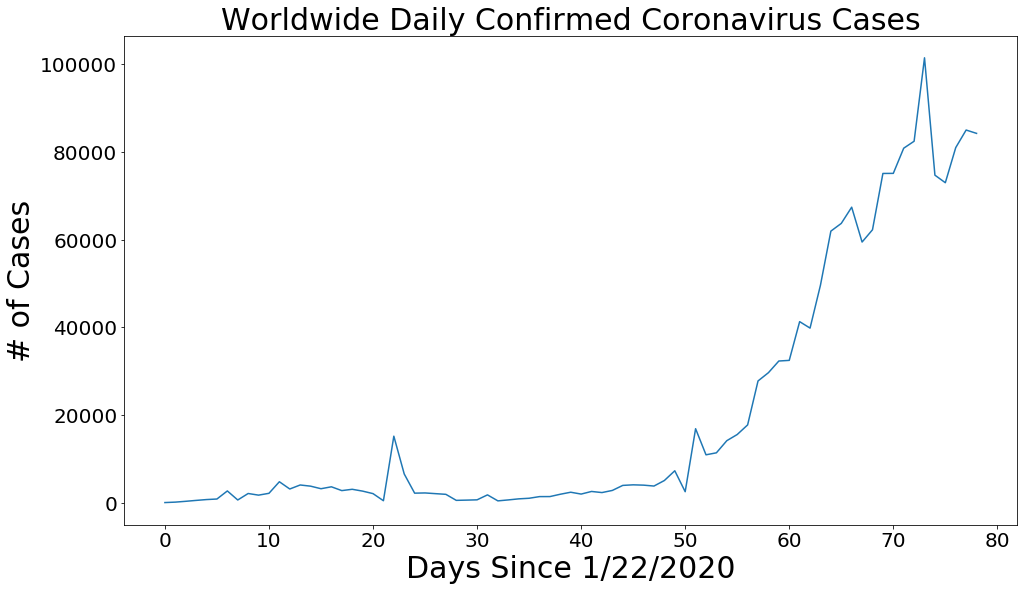

In [14]:
#hide_input
adjusted_dates = adjusted_dates.reshape(1, -1)[0]
plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, world_cases)
plt.title('Worldwide Daily Confirmed Coronavirus Cases', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

## Daily confirmed cases of Number of Countries

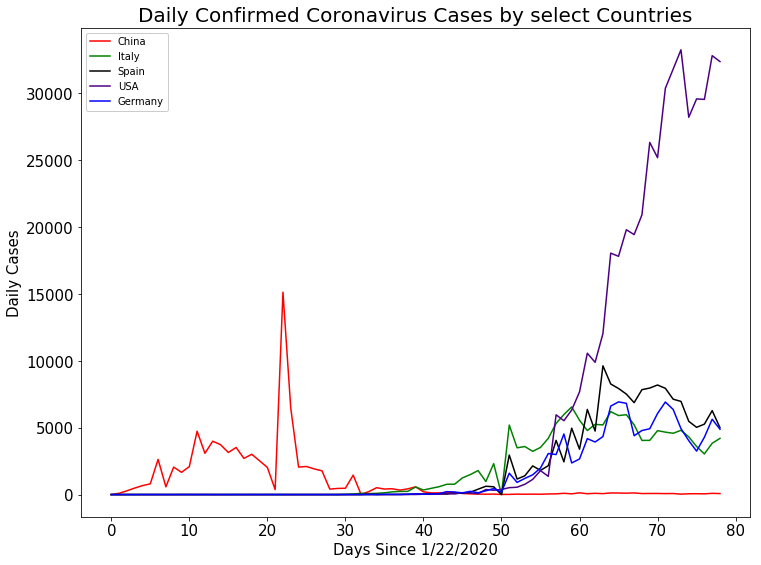

In [15]:
#hide_input
plt.figure(figsize=(12, 9))
plt.plot(adjusted_dates, china_cases, color='red', label='China')
plt.plot(adjusted_dates, italy_cases, color='green', label='Italy')
plt.plot(adjusted_dates, spain_cases, color='black', label='Spain')
plt.plot(adjusted_dates, us_cases, color='indigo', label='USA')
plt.plot(adjusted_dates, germany_cases, color='blue', label='Germany')
plt.legend(framealpha=1, frameon=True)
plt.title('Daily Confirmed Coronavirus Cases by select Countries', size=20)
plt.xlabel('Days Since 1/22/2020', size=15)
plt.ylabel('Daily Cases', size=15)
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

**China has flattened the curve whiles Italy, Germany, Spain fluctuated in recording number of cases from daay 50. The USA is still recording high number of cases. Spain and Germany are closely related in reporting daily cases.